## Producing Insights for Clients

In [1]:
import pandas as pd
import numpy as np
import xlrd
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Download data

In [2]:
df=pd.read_csv('./DataRaw.csv')
df

,TxnDateTime,spendout,UserKey,MerchantTag,UserPostalSector
0,2022-01-30,-18.24,207213E18150,asda,G781
1,2022-01-31,-1.00,5C4B04A9F05D,asda,LE36
2,2022-01-31,-68.95,A3610CF3A565,asda,OL14
3,2022-01-31,-45.12,F372B40275E8,asda,NE639
4,2022-01-27,-93.34,EA139F1D3902,asda,EH546
...,...,...,...,...,...
2675093,2022-03-26,-29.48,8372EC04277B,lidl,E126
2675094,2022-03-26,-8.13,2BA3F0A4FD5C,lidl,LU11
2675095,2022-03-27,-1.15,7B131BB412FD,lidl,M94
2675096,2022-03-24,-42.46,66E6F56BF544,lidl,E178


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675098 entries, 0 to 2675097
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   TxnDateTime       object 
 1   spendout          float64
 2   UserKey           object 
 3   MerchantTag       object 
 4   UserPostalSector  object 
dtypes: float64(1), object(4)
memory usage: 102.0+ MB


##### Description of FableDataRow.csv:

TxnDateTime (object) - date of the transaction;

spendout (float64) - transaction amount;

UserKey (object) - user identifier;

MerchantTag (object) - brand name;

UserPostalSector (object) - poster sector of user.

### Preprocessing data

In [4]:
# Define duplicates
duplicateRows = df[df.duplicated ()]

In [5]:
duplicateRows

,TxnDateTime,spendout,UserKey,MerchantTag,UserPostalSector
5993,2021-12-08,-12.00,30FAC349EF17,asda,DE217
7214,2022-01-21,-50.00,7D68B1ECB464,asda,BD74
10468,2022-02-04,0.00,B63EB7BF973C,asda,CV64
12968,2022-03-07,-5.50,2DF97BF8EB03,asda,SE186
14644,2021-10-21,-75.00,F9C422826B48,asda,W36
...,...,...,...,...,...
2674411,2021-11-04,0.00,3B3CF48B94E2,asda,TQ149
2674412,2021-11-20,0.00,FE8DB89CE68D,asda,G673
2674469,2021-11-14,0.00,C5FDEB6ECDFC,asda,BH211
2674470,2022-03-31,0.00,E9C8F0BFF588,asda,M167


In [6]:
# Delete duplicates
df=df.drop_duplicates()

In [7]:
# Convert a date column "TxnDateTime" from an object to a datatime data type.
df['TxnDateTime']=pd.to_datetime(df['TxnDateTime'], format="%Y/%m/%d")

In [94]:
df["Year_month"] = df["TxnDateTime"].dt.to_period("M")

In [101]:
df['Year_month']=df['Year_month'].values.astype('datetime64[M]')

In [8]:
# Create new columns: "Month", "Week" (days of the week)
df["Month"] = df['TxnDateTime'].dt.month
df["Week"] = df['TxnDateTime'].dt.day_name()

In [11]:
# Changed the sign in front of the entire column "spendout" for better understanding and visualizations.
df['spendout']=df['spendout'].abs()

In [104]:
df

,TxnDateTime,spendout,UserKey,MerchantTag,UserPostalSector,Month,Week,Year_month
0,2022-01-30,18.24,207213E18150,asda,G781,1,Sunday,2022-01-01
1,2022-01-31,1.00,5C4B04A9F05D,asda,LE36,1,Monday,2022-01-01
2,2022-01-31,68.95,A3610CF3A565,asda,OL14,1,Monday,2022-01-01
3,2022-01-31,45.12,F372B40275E8,asda,NE639,1,Monday,2022-01-01
4,2022-01-27,93.34,EA139F1D3902,asda,EH546,1,Thursday,2022-01-01
...,...,...,...,...,...,...,...,...
2675093,2022-03-26,29.48,8372EC04277B,lidl,E126,3,Saturday,2022-03-01
2675094,2022-03-26,8.13,2BA3F0A4FD5C,lidl,LU11,3,Saturday,2022-03-01
2675095,2022-03-27,1.15,7B131BB412FD,lidl,M94,3,Sunday,2022-03-01
2675096,2022-03-24,42.46,66E6F56BF544,lidl,E178,3,Thursday,2022-03-01


In [110]:
# Create new data tables grouped by spending amount , mean amount and number of transactions per month 
df_month_sum=df[['Year_month','MerchantTag', 'UserKey', 'spendout']].groupby(['Year_month','MerchantTag', 'UserKey']).sum()
df_month_cnt=df[['Year_month','MerchantTag', 'UserKey', 'spendout']].groupby(['Year_month','MerchantTag', 'UserKey']).count()
df_month_mean=df[['Year_month','MerchantTag', 'UserKey', 'spendout']].groupby(['Year_month','MerchantTag', 'UserKey']).mean()

In [25]:
# Create new data tables grouped by spending amount and number of transactions per day
df_day_sum=df[['TxnDateTime','MerchantTag', 'spendout']].groupby(['TxnDateTime','MerchantTag']).sum()
df_day_cnt=df[['TxnDateTime','MerchantTag', 'spendout']].groupby(['TxnDateTime','MerchantTag']).count()

### Pandas profiling

In [16]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA - Exploratory Data Analysis

In [14]:
df.describe()

,spendout,Month
count,2.669580e+06,2.669580e+06
mean,2.758448e+01,6.570742e+00
std,3.142362e+01,4.564930e+00
min,0.000000e+00,1.000000e+00
25%,8.000000e+00,2.000000e+00
50%,1.760000e+01,1.000000e+01
75%,3.566000e+01,1.100000e+01
max,4.149000e+03,1.200000e+01


<AxesSubplot:>

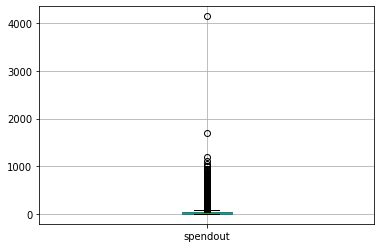

In [15]:
# Boxplot of "spendout"
df.boxplot(column=['spendout'])

We will not consider this point as an outlier, because this may be a unique case when such a large transaction occurred

In [18]:
palette = ['#72E652', '#00DAFF']

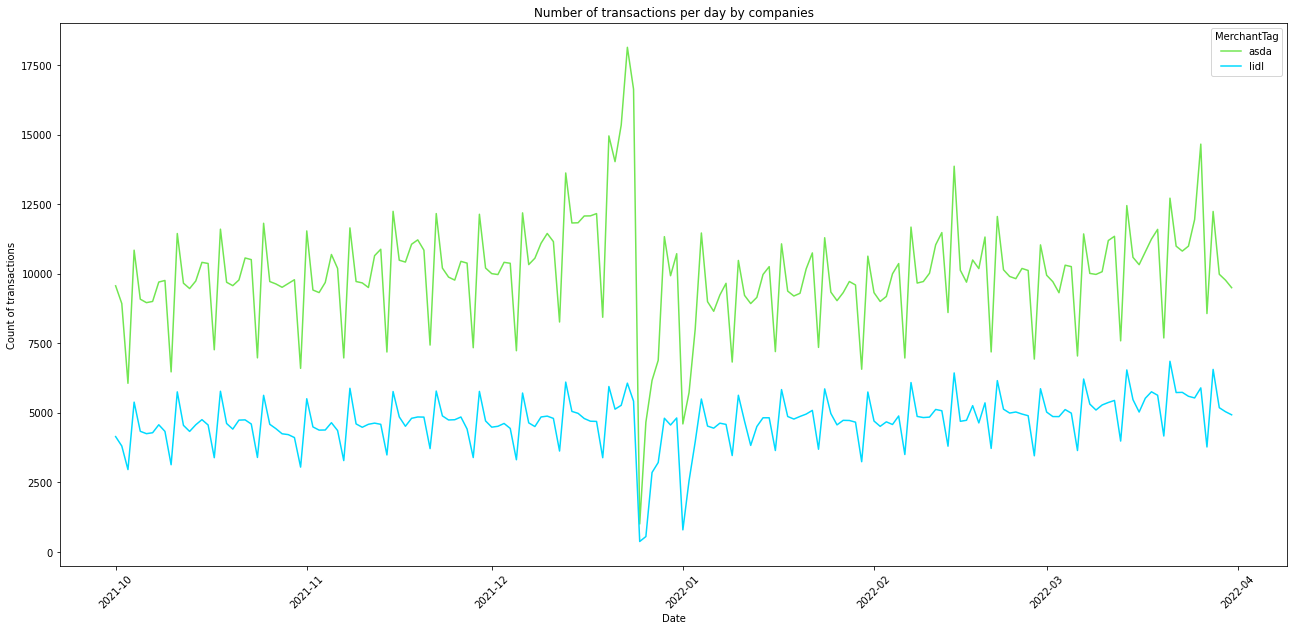

In [30]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="TxnDateTime", y="spendout", hue="MerchantTag", data=df_day_cnt, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Count of transactions')
plt.title('Number of transactions per day by companies')
plt.xticks(rotation=45)
plt.show()

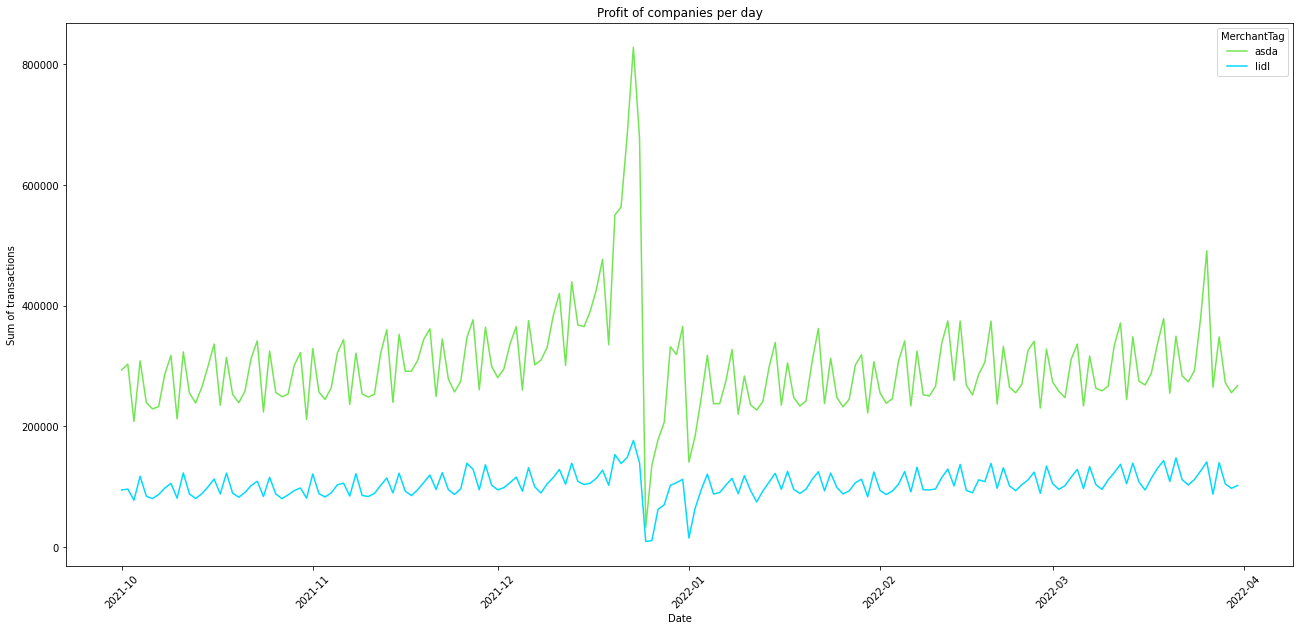

In [31]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="TxnDateTime", y="spendout", hue="MerchantTag", data=df_day_sum, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Sum of transactions')
plt.title('Profit of companies per day')
plt.xticks(rotation=45)
plt.show()

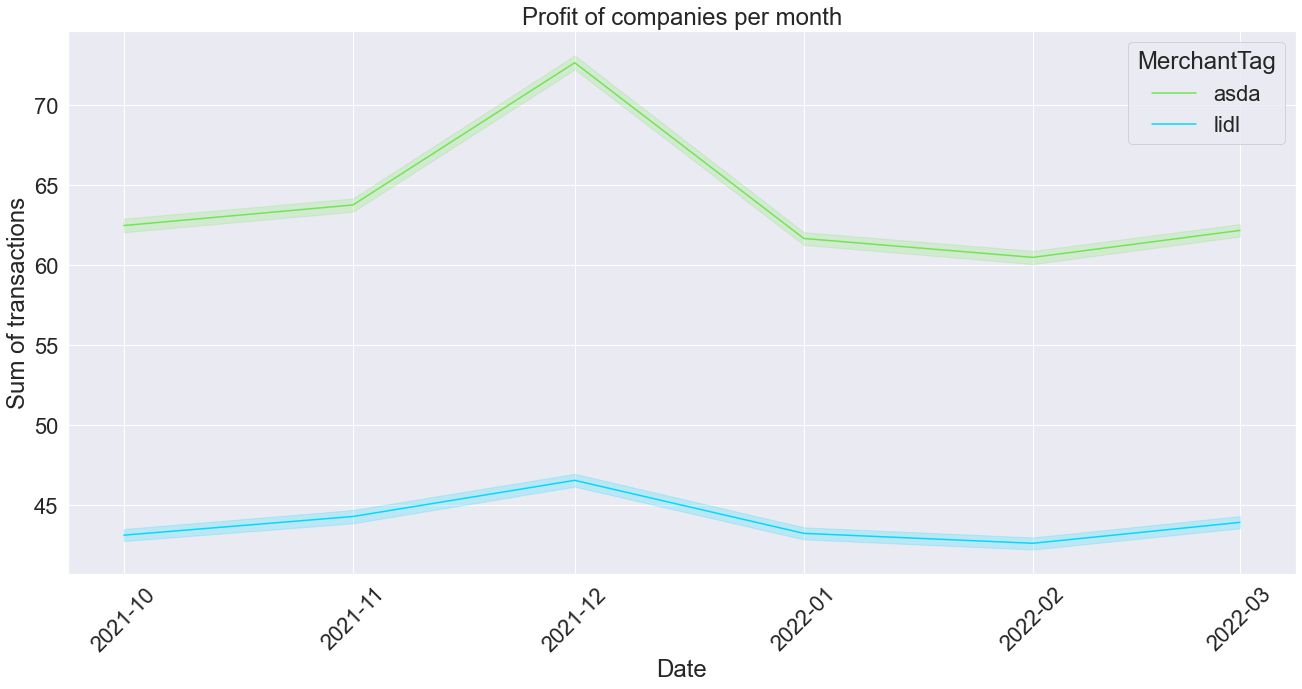

In [108]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="Year_month", y="spendout", hue="MerchantTag", data=df_month_sum, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Sum of transactions')
plt.title('Profit of companies per month')
plt.xticks(rotation=45)
plt.show()

Asda has an initial sharp rise, followed by a strong drop in demand during the pre-Christmas period, which causes a drop in profits. Perhaps it doesn’t work or doesn’t present themed products, the lead also has a small drawdown in the number of transactions during this period, but the volatility is not as strong as that of a competitor, so the profit remains approximately at the same level.

In this case, a recommendation can be given to take advantage of this opportunity to offer something special for the holidays so that asda buyers move to lidl during this period.

The charts also show a cycle every week.

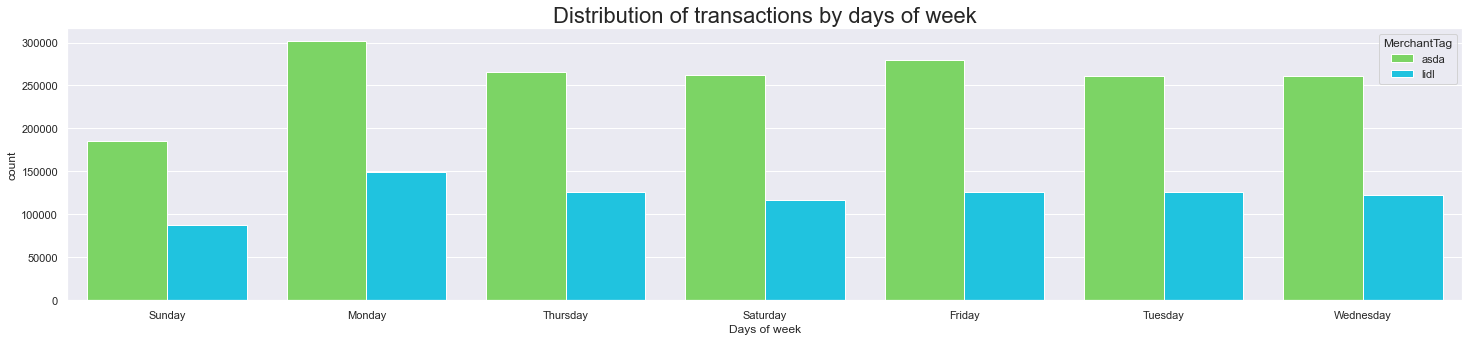

In [38]:
sns.set(font_scale=1)
plt.figure(figsize=(25, 5))
sns.countplot(x='Week', data=df, hue='MerchantTag', palette = palette)
plt.title('Distribution of transactions by days of week', fontsize=22)
plt.xlabel('Days of week')
plt.show()
sns.set(font_scale=2)

At Lidl, all days of the week are in approximately the same demand, except for Monday, which is the highest, Friday the next one and Sunday is the lowest. Asda has a similar situation.

I think this is due to the fact that on Monday people usually go to such stores to buy goods for the week. And on Friday, people are preparing for the weekend, perhaps guests are coming or a party is planned. And Sunday is a full day for rest.

As a recommendation for Lidl, I would suggest adding discounts on items that are on the shelves during peak sales so that people are motivated to come on other days, such as Sunday.

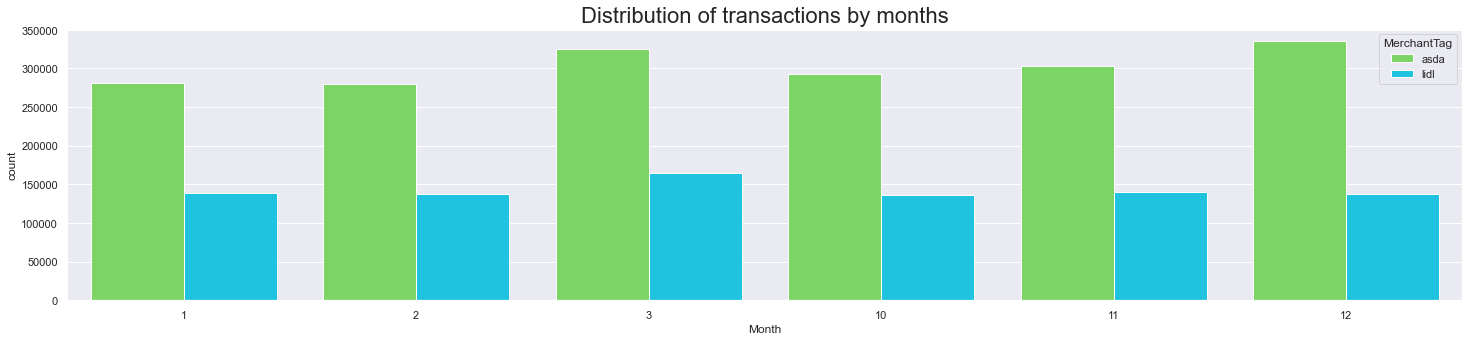

In [127]:
sns.set(font_scale=1)
plt.figure(figsize=(25, 5))
sns.countplot(x='Month', data=df, hue='MerchantTag', palette = palette)
plt.title('Distribution of transactions by months', fontsize=22)
plt.xlabel('Month')
plt.show()
sns.set(font_scale=2)

March and December stand out for asda. Perhaps, the first month of spring, the improvement of the weather encourages people to go outside, walk to the store. And in December, everyone always goes for various goods to prepare for the holidays, so the fact that December is the leading month is not surprising. For Lidl, only March stands out from the rest of the months in our dataset.

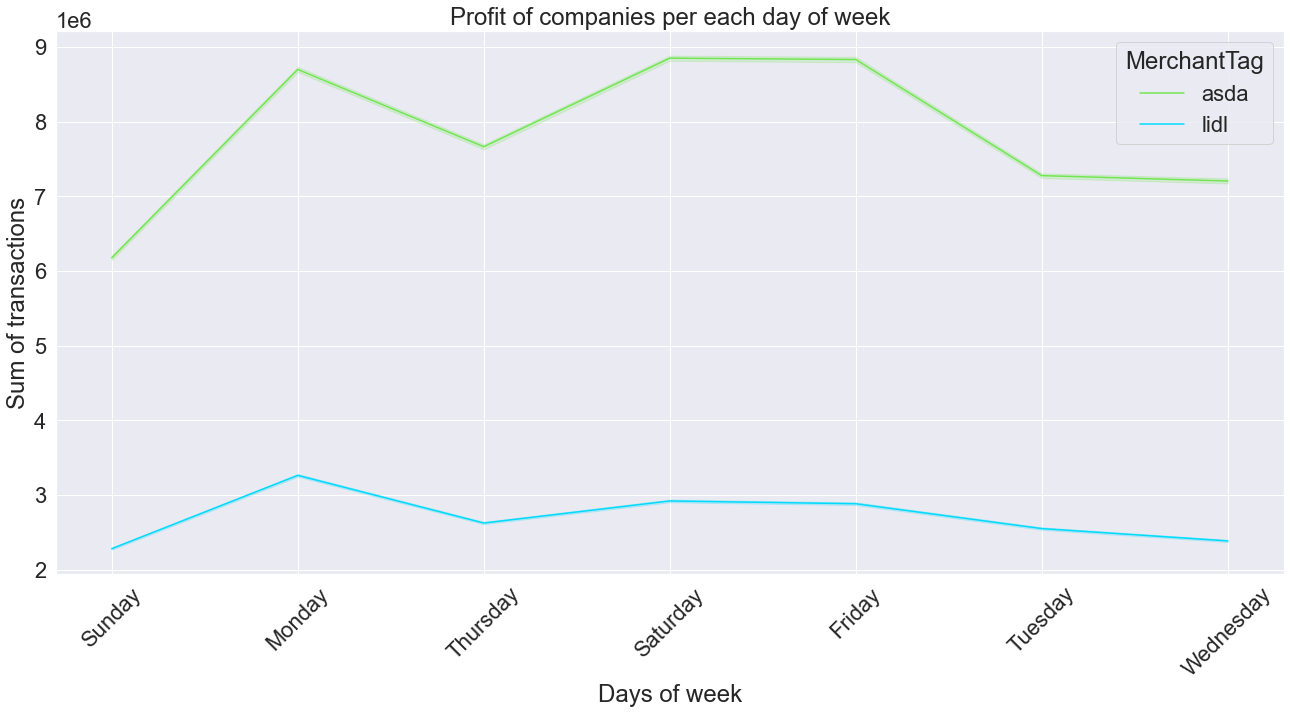

In [37]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="Week", y="spendout", hue="MerchantTag", data=df, estimator=np.sum, palette = palette)
ax = ax.set(xlabel='Days of week', ylabel='Sum of transactions')
plt.title('Profit of companies per each day of week')
plt.xticks(rotation=45)
plt.show()

Trends in the growth and fall of profits for companies occur on the same days of the week, but for asda they are sharper.

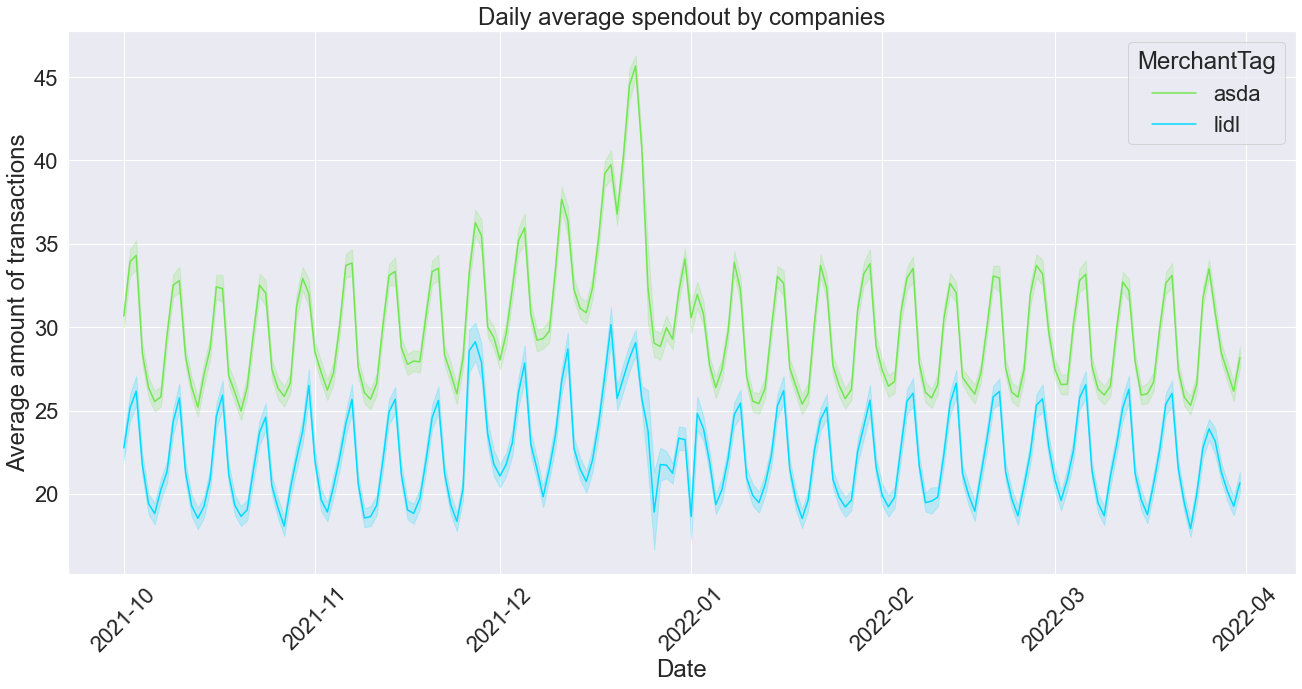

In [128]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="TxnDateTime", y="spendout", hue="MerchantTag", data=df, estimator=np.mean, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Average amount of transactions')
plt.title('Daily average spendout by companies')
plt.xticks(rotation=45)
plt.show()

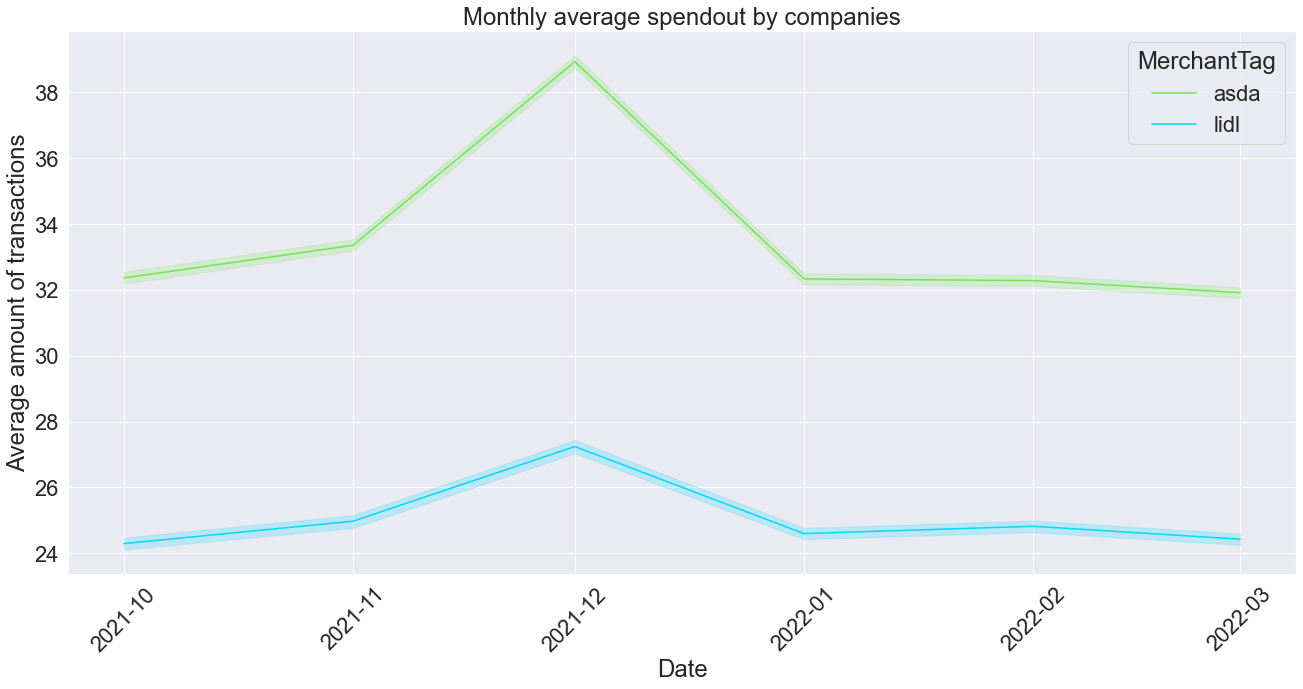

In [129]:
f, axes = plt.subplots(figsize=(22, 10), sharex=True)
ax = sns.lineplot(x="Year_month", y="spendout", hue="MerchantTag", data=df_month_mean, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Average amount of transactions')
plt.title('Monthly average spendout by companies')
plt.xticks(rotation=45)
plt.show()

The average check shows that the cost of the food basket in asda is higher than in lidl, which indicates that the lidl is aimed at people with lower earnings.

Lidl could try to expand its product segment and target different populations to boost profit.

In [42]:
# Create new dayly data table grouped by number of unique users
df_unique=df[['TxnDateTime','MerchantTag', 'UserKey']].groupby(['TxnDateTime','MerchantTag']).nunique()

In [43]:
# Create new data table grouped by number of user in different locations
df_unique_loc=df[['MerchantTag', 'UserPostalSector', 'UserKey']].groupby(['MerchantTag','UserPostalSector']).count()

In [114]:
# Create new monthly data table grouped by number of unique users
df_unique_month=df[['Year_month','MerchantTag', 'UserKey']].groupby(['Year_month','MerchantTag']).nunique()

In [115]:
# Create new monthly data table grouped by transactions amount
df_spend_sum_month=df[['Year_month','MerchantTag', 'spendout']].groupby(['Year_month','MerchantTag']).sum()

In [116]:
# Combine two new tables
share_users = pd.concat([df_spend_sum_month, df_unique_month],axis=1) 

In [117]:
# Create new column "Profit_per_unique_user"
share_users['Profit_per_unique_user']=share_users['spendout']//share_users['UserKey']

In [118]:
share_users

spendout  UserKey  Profit_per_unique_user
Year_month MerchantTag                                              
2021-10-01 asda          8440477.95   135099                    62.0
           lidl          2918747.32    67647                    43.0
2021-11-01 asda          8992360.55   141033                    63.0
           lidl          3077511.02    69453                    44.0
2021-12-01 asda         11630341.15   160110                    72.0
           lidl          3307569.30    71027                    46.0
2022-01-01 asda          8165483.57   132408                    61.0
           lidl          3042297.43    70328                    43.0
2022-02-01 asda          8147161.19   134690                    60.0
           lidl          3018182.71    70784                    42.0
2022-03-01 asda          9339796.27   150230                    62.0
           lidl          3559043.66    80989                    43.0

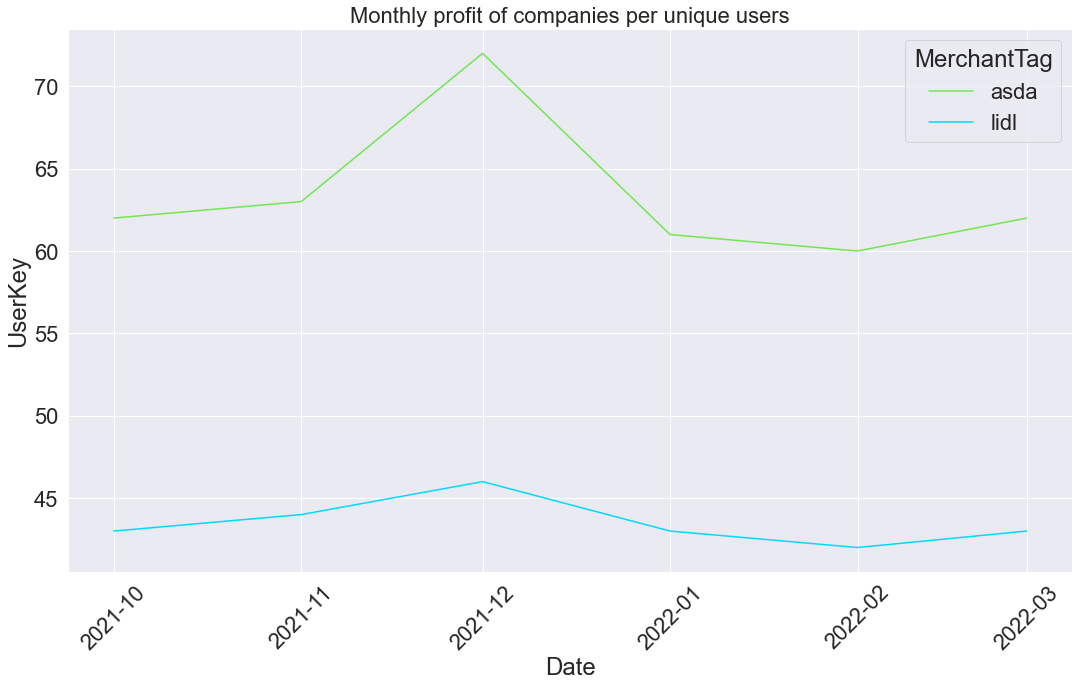

In [130]:
plt.figure(figsize = (18,10))
plt.title('Monthly profit of companies per unique users', fontsize=22)
ax = sns.lineplot(x='Year_month', y="Profit_per_unique_user", hue="MerchantTag", data=share_users, palette = palette)
ax = ax.set(xlabel='Date', ylabel='UserKey')
plt.xticks(rotation=45)
plt.show()

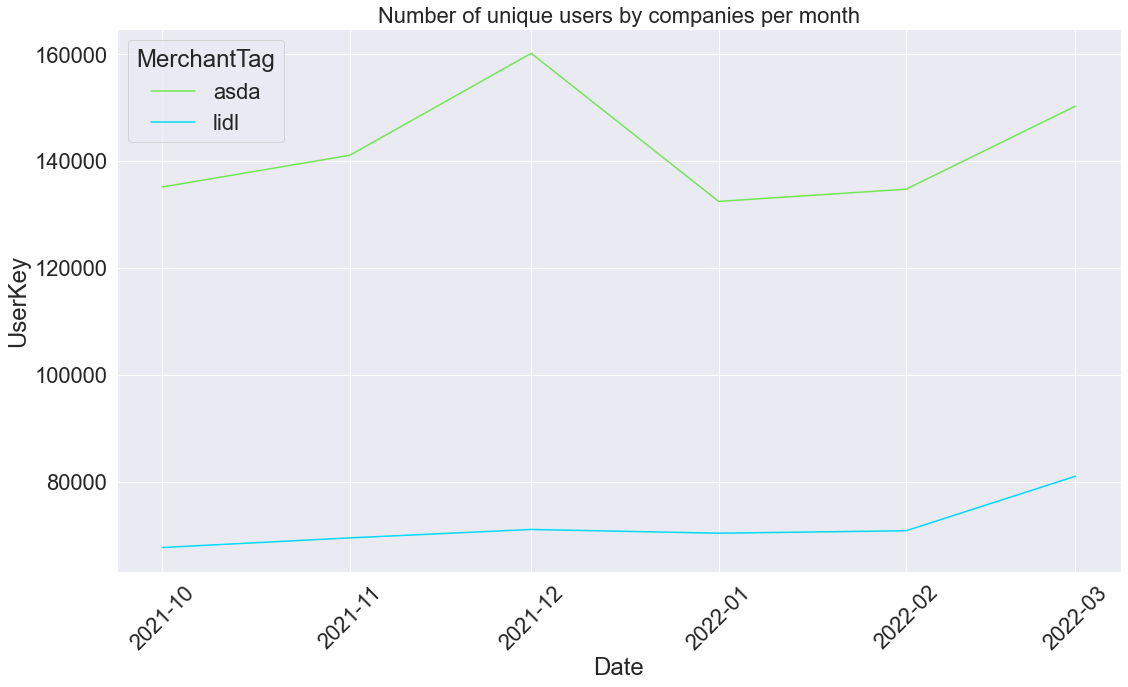

In [120]:
plt.figure(figsize = (18,10))
plt.title('Number of unique users by companies per month', fontsize=22)
ax = sns.lineplot(x='Year_month', y="UserKey", hue="MerchantTag", data=share_users, palette = palette)
ax = ax.set(xlabel='Date', ylabel='UserKey')
plt.xticks(rotation=45)
plt.show()

Profit from unique users depends on the number of unique users of companies per month.

Recommendation: make profitable offers for buyers so that buyers come back again and again.

In [121]:
# Create new monthly data table grouped by number of transactions 
df_spend_cnt_month=df[['Year_month','MerchantTag', 'spendout']].groupby(['Year_month','MerchantTag']).count()

In [122]:
# Combine two new tables
share_users_2 = pd.concat([df_spend_cnt_month, df_unique_month],axis=1) 

In [123]:
# Create new column "Profit_per_unique_user"
share_users_2['Avg_txn_amount_per_unique_user']=share_users_2['spendout']/share_users_2['UserKey']

In [124]:
share_users_2

spendout  UserKey  Avg_txn_amount_per_unique_user
Year_month MerchantTag                                                   
2021-10-01 asda           292129   135099                        2.162333
           lidl           135742    67647                        2.006623
2021-11-01 asda           303285   141033                        2.150454
           lidl           140030    69453                        2.016184
2021-12-01 asda           334828   160110                        2.091237
           lidl           137178    71027                        1.931350
2022-01-01 asda           281087   132408                        2.122885
           lidl           139074    70328                        1.977505
2022-02-01 asda           280097   134690                        2.079568
           lidl           136870    70784                        1.933629
2022-03-01 asda           325032   150230                        2.163563
           lidl           164228    80989                        2.027782

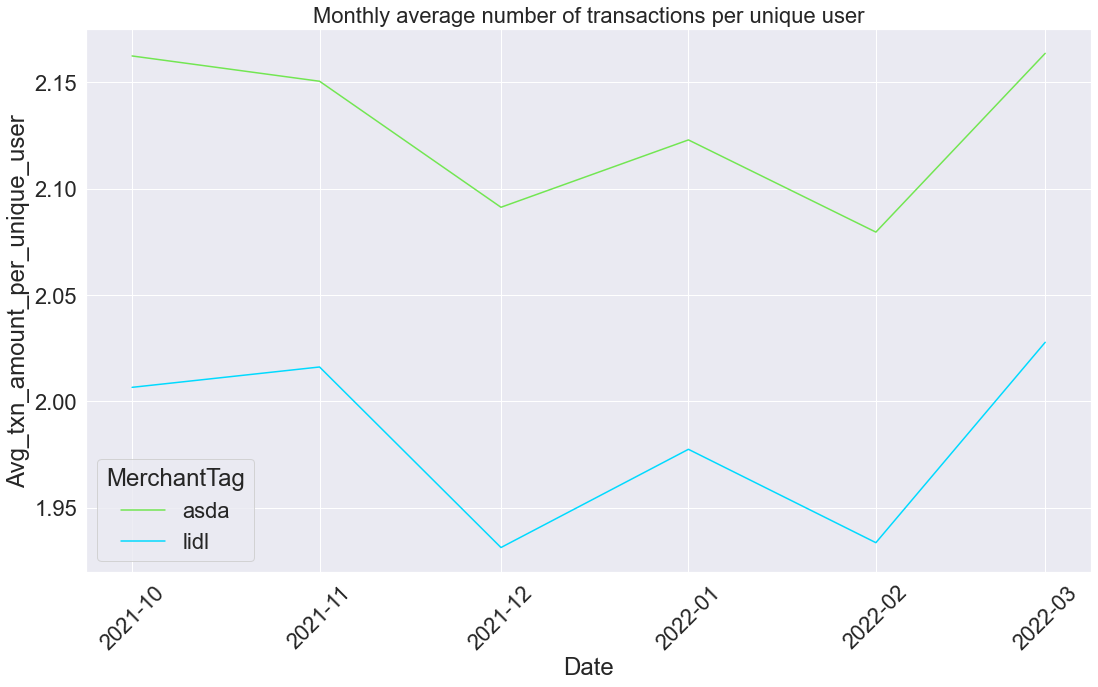

In [125]:
plt.figure(figsize = (18,10))
plt.title('Monthly average number of transactions per unique user', fontsize=22)
ax = sns.lineplot(x='Year_month', y="Avg_txn_amount_per_unique_user", hue="MerchantTag", data=share_users_2, palette = palette)
ax = ax.set(xlabel='Date', ylabel='Avg_txn_amount_per_unique_user')
plt.xticks(rotation=45)
plt.show()

On average, customers are more loyal to a competitor, as they visit a little more often than lidl, which confirms that the lidl brand needs to increase its loyalty to customers.

## Metrics

1. Monthly profit by companies - shows the scale of the company compared to a competitor / the entire market, allows you to determine the dynamics of revenue for the operational management of the company
2. The number of transactions per day of the week and per month by company - by day of the week allows you to understand the activity of buyers, which helps in the tactical management of stores (discounts, filling goods, staff loading, etc.), data by month helps to determine the industry's propensity for seasonality
3. The amount of expenses (profit) per days of the week by company - repeats 1 and 2, you can make an average check by day of the week, which will show the tendency of buyers to spend money on certain days
4. Daily and monthly average spendout by company - allows you to understand the grocery basket of our customers and assess which class we are in (ultra-economy, economy, etc.)
5. Monthly profit per unique users by company (all profit per the month / number of unique clients) - this shows how much the average client spends on us per month, namely the amount of wallet that the average client leaves with us.
6. The number of unique users per month by company - shows how our marketing works, whether new customers come to us
7. Number of transactions per month \ number of unique users - shows how many times an average client visits us on average

## Insights of Lidl

1. The peak of profit falls on the winter holidays
2. Lidl is most in demand on Monday and Friday, and least on Sunday
3. The largest number of transactions was made in March 2022
4. Despite the growth of unique users, profit remained at the same level in 6 months
5. Lidl's average check in December is at its all-time high.
6. Competitor's wallets are higher than Lidl's.
7. lidl is aimed at people with lower earnings
8. Lidl has lower customer loyalty than its rival Asda.